In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
import cv2
import time
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torch import optim
from matplotlib import pyplot as plt
from torch import optim
from PIL import Image
%matplotlib inline

In [2]:
Data_floder = "E:\Classes\Machine learning\ML_6CFU\Projects\Gans\Train\Data"

In [3]:
len(os.listdir(Data_floder))

2782

In [4]:
highest_length=highest_width=lowest_width=lowest_length = 0
flag_l =True
flag_w =True
avg_length =0
avg_width = 0
name_hl= name_hw= name_ll =name_lw=Data_floder
for name in os.listdir(Data_floder):
            img = plt.imread(Data_floder+"\\"+name)
            avg_length  = avg_length + img.shape[0]
            avg_width  = avg_width + img.shape[1]
            if img.shape[0]> highest_length:
                highest_length = img.shape[0]
                name_hl= name_hl[:60]+"\\"+name
            if  img.shape[1] > highest_width:
                highest_width = img.shape[1]
                name_hw=name_hw[:60]+"\\"+name
            if (img.shape[0]< lowest_length)or flag_l:
                lowest_length = img.shape[0]
                name_ll = name_ll[:60]+"\\"+name
                flag_l=False
            if  img.shape[1] < lowest_width or flag_w:
                lowest_width = img.shape[1]
                name_lw= name_lw[:60]+"\\"+name
                flag_w=False
    
print("the max row , max col , min row , min col , avg row ,and avg col is {}, {}, {}, {}, {}, {} respectively ".format(
                                        highest_length,highest_width,lowest_length,lowest_width,
                                        int(avg_length/2782),int(avg_width/2782)))


the max row , max col , min row , min col , avg row ,and avg col is 4075, 3953, 116, 103, 627, 629 respectively 


In [5]:
print("the name of the highest row image is: {},\n"
      "the name of the highest col image is: {},\n"
      "the name of the lowest  row image is: {},\n"
      "the name of the lowest  col image is: {}".format(name_hl[61:],name_hw[61:],name_ll[61:],name_lw[61:]))

the name of the highest row image is: Abstract_image_1610.jpg,
the name of the highest col image is: Abstract_image_2126.jpg,
the name of the lowest  row image is: Abstract_image_202.jpg,
the name of the lowest  col image is: Abstract_image_2774.jpg


In [6]:
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

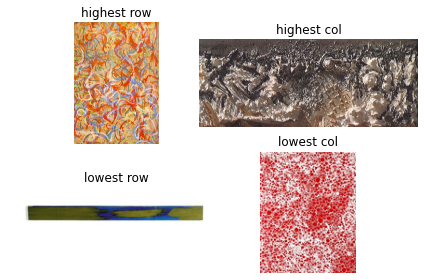

In [7]:
images={}
for x,y in zip([name_hl,name_hw,name_ll,name_lw],['highest row','highest col', 'lowest row','lowest col']):
    images[y] = plt.imread(x)
display_multiple_img(images, 2, 2)

In [8]:
dataroot = 'E:\Classes\Machine learning\ML_6CFU\Projects\Gans\Train'
workers = 4
batch_size = 8
nz = 100
num_epochs = 15
beta1 = 0.5
ngpu = 1

In [9]:
dataset = ImageFolder(root=dataroot,
                            transform=transforms.Compose([
                            transforms.Resize(540,interpolation=Image.BICUBIC),
                            transforms.CenterCrop(512),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [10]:
dataset

Dataset ImageFolder
    Number of datapoints: 2782
    Root location: E:\Classes\Machine learning\ML_6CFU\Projects\Gans\Train
    StandardTransform
Transform: Compose(
               Resize(size=540, interpolation=PIL.Image.BICUBIC)
               CenterCrop(size=(512, 512))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [14]:
dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 2782
    Root location: E:\Classes\Machine learning\ML_6CFU\Projects\Gans\Train
    StandardTransform
Transform: Compose(
               Resize(size=540, interpolation=PIL.Image.BICUBIC)
               CenterCrop(size=(512, 512))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [15]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [16]:
device

device(type='cuda', index=0)

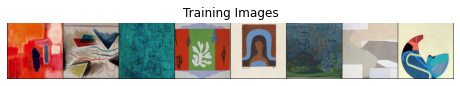

In [17]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=4, normalize=True).cpu(),(1,2,0)))

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( nz, 512, 6, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 512, 4, 2, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( 512, 256, 4, 2, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( 256, 256, 4, 2, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( 256, 128, 6, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
           
            nn.ConvTranspose2d( 128, 64, 6, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( 64, 3, 8, 2, 1, bias=False),
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)

In [20]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [21]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 8, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 6, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 6, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 256, 4, 2, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 512, 4, 2, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 6, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [22]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track

In [23]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(8, nz, 1, 1, device=device)
optimizerD = optim.Adam(netD.parameters(), lr=0.00011, betas=(beta1, 0.6))
optimizerG = optim.Adam(netG.parameters(), lr=0.00017, betas=(beta1, 0.6))

In [24]:
netG.load_state_dict(torch.load('G.pth'))
netD.load_state_dict(torch.load('D.pth'))

<All keys matched successfully>

In [25]:
img_list = []
G_losses = []
D_losses = []
iters = 0
for epoch in range(num_epochs):
    
    for i, data in enumerate(dataloader, 0):

        
        netD.zero_grad()
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = ((1-0.8)*torch.rand((b_size)) + 0.8).to(device)
        
        output = netD(real_cpu).view(-1)
        
        errD_real = criterion(output, label)
        
        errD_real.backward()
        D_x = output.mean().item()

       
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        fake = netG(noise)
        label = ((0.05-0.0)*torch.rand((b_size)) + 0.00).to(device)
        
        output = netD(fake.detach()).view(-1)
        
        errD_fake = criterion(output, label)
        
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()

        
        
        netG.zero_grad()
        label = ((1-0.8)*torch.rand((b_size)) + 0.8).to(device)
        
        output = netD(fake).view(-1)
        
        errG = criterion(output, label)
       
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=4, normalize=True))

        iters += 1

[0/15][0/348]	Loss_D: 109.9755	Loss_G: 7.8030	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


KeyboardInterrupt: 

In [ ]:
torch.save(netD.state_dict(), "D.pth")
torch.save(netG.state_dict(), "G.pth")

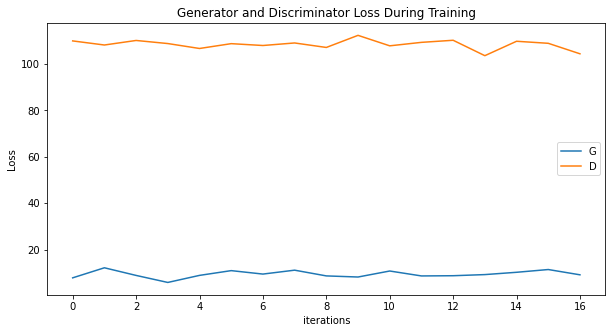

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

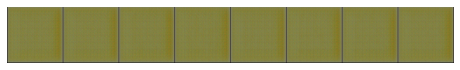

In [27]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


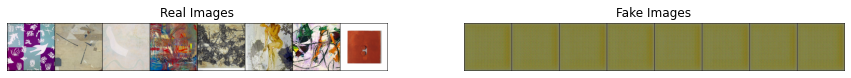

In [28]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()